In [1]:
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from io import StringIO
from math import sqrt
import numpy as np
import scipy.stats as st
from scipy.fftpack import fft, fftfreq
from scipy.signal import argrelextrema
import operator
import os
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV

from time import time
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/FallDetectionAI/Dataset/updated_dataset_extract.csv')

In [3]:
df.head()

,Unnamed: 0,max_acc_re_raw,std_acc_re_raw,var_acc_re_raw,iqr_acc_re_raw,mad_acc_re_raw,max_acc_re_jerk,min_acc_re_jerk,range_acc_re_jerk,std_acc_re_jerk,...,iqr_gyro_re_raw,mad_gyro_re_raw,max_gyro_re_jerk,min_gyro_re_jerk,range_gyro_re_jerk,std_gyro_re_jerk,var_gyro_re_jerk,mad_gyro_re_jerk,fall_adl_bin,person_id
0,7,76.036896,10.008718,100.174436,5.566221,2.940210,39.913594,-36.025112,75.938706,6.746976,...,1.449972,0.698264,1.485122,-2.185508,3.670631,0.483618,0.233887,0.221804,1,P01
1,14,27.640774,5.992467,35.909656,10.007666,3.966184,11.271461,-14.967072,26.238534,3.753407,...,2.765061,1.205626,2.221515,-1.499693,3.721207,0.499416,0.249417,0.117655,1,P01
2,18,37.257846,6.346144,40.273544,9.312719,3.710783,19.888154,-8.400244,28.288399,3.218299,...,1.487817,0.834027,3.229411,-1.426427,4.655839,0.511617,0.261752,0.143988,1,P01
3,35,93.610890,10.095335,101.915796,7.518415,3.999902,75.824978,-69.053640,144.878618,12.108991,...,2.265150,1.091244,3.786974,-2.523516,6.310490,0.743834,0.553290,0.296161,1,P01
4,63,54.818089,9.130829,83.372032,4.909636,1.666575,19.117149,-27.576834,46.693983,5.637666,...,2.906405,0.877341,3.295670,-1.048350,4.344020,0.607688,0.369285,0.075793,1,P01


In [4]:
person_ids = df.pop('person_id')

In [5]:
person_ids = person_ids.to_numpy()
person_ids[:5]

array(['P01', 'P01', 'P01', 'P01', 'P01'], dtype=object)

In [6]:
len(person_ids)

839

In [7]:
len(df)

839

In [8]:
df.head()

,Unnamed: 0,max_acc_re_raw,std_acc_re_raw,var_acc_re_raw,iqr_acc_re_raw,mad_acc_re_raw,max_acc_re_jerk,min_acc_re_jerk,range_acc_re_jerk,std_acc_re_jerk,...,var_gyro_re_raw,iqr_gyro_re_raw,mad_gyro_re_raw,max_gyro_re_jerk,min_gyro_re_jerk,range_gyro_re_jerk,std_gyro_re_jerk,var_gyro_re_jerk,mad_gyro_re_jerk,fall_adl_bin
0,7,76.036896,10.008718,100.174436,5.566221,2.940210,39.913594,-36.025112,75.938706,6.746976,...,0.919414,1.449972,0.698264,1.485122,-2.185508,3.670631,0.483618,0.233887,0.221804,1
1,14,27.640774,5.992467,35.909656,10.007666,3.966184,11.271461,-14.967072,26.238534,3.753407,...,2.339850,2.765061,1.205626,2.221515,-1.499693,3.721207,0.499416,0.249417,0.117655,1
2,18,37.257846,6.346144,40.273544,9.312719,3.710783,19.888154,-8.400244,28.288399,3.218299,...,1.957177,1.487817,0.834027,3.229411,-1.426427,4.655839,0.511617,0.261752,0.143988,1
3,35,93.610890,10.095335,101.915796,7.518415,3.999902,75.824978,-69.053640,144.878618,12.108991,...,1.831407,2.265150,1.091244,3.786974,-2.523516,6.310490,0.743834,0.553290,0.296161,1
4,63,54.818089,9.130829,83.372032,4.909636,1.666575,19.117149,-27.576834,46.693983,5.637666,...,2.660907,2.906405,0.877341,3.295670,-1.048350,4.344020,0.607688,0.369285,0.075793,1


In [9]:
y_train = df.pop('fall_adl_bin')

In [10]:
X_train = df.drop(df.columns[0], axis=1)

In [11]:
X_train.head()

,max_acc_re_raw,std_acc_re_raw,var_acc_re_raw,iqr_acc_re_raw,mad_acc_re_raw,max_acc_re_jerk,min_acc_re_jerk,range_acc_re_jerk,std_acc_re_jerk,var_acc_re_jerk,...,std_gyro_re_raw,var_gyro_re_raw,iqr_gyro_re_raw,mad_gyro_re_raw,max_gyro_re_jerk,min_gyro_re_jerk,range_gyro_re_jerk,std_gyro_re_jerk,var_gyro_re_jerk,mad_gyro_re_jerk
0,76.036896,10.008718,100.174436,5.566221,2.940210,39.913594,-36.025112,75.938706,6.746976,45.521692,...,0.958861,0.919414,1.449972,0.698264,1.485122,-2.185508,3.670631,0.483618,0.233887,0.221804
1,27.640774,5.992467,35.909656,10.007666,3.966184,11.271461,-14.967072,26.238534,3.753407,14.088064,...,1.529657,2.339850,2.765061,1.205626,2.221515,-1.499693,3.721207,0.499416,0.249417,0.117655
2,37.257846,6.346144,40.273544,9.312719,3.710783,19.888154,-8.400244,28.288399,3.218299,10.357448,...,1.398992,1.957177,1.487817,0.834027,3.229411,-1.426427,4.655839,0.511617,0.261752,0.143988
3,93.610890,10.095335,101.915796,7.518415,3.999902,75.824978,-69.053640,144.878618,12.108991,146.627661,...,1.353295,1.831407,2.265150,1.091244,3.786974,-2.523516,6.310490,0.743834,0.553290,0.296161
4,54.818089,9.130829,83.372032,4.909636,1.666575,19.117149,-27.576834,46.693983,5.637666,31.783275,...,1.631229,2.660907,2.906405,0.877341,3.295670,-1.048350,4.344020,0.607688,0.369285,0.075793


In [14]:
def train_and_evaluate(X_train_val, y_train_val, person_ids):
    """
    Perform group k-fold cross-validation with grid search to find the best model.

    Parameters:
    - X_train_val: Feature matrix.
    - y_train_val: Target labels.
    - person_ids: Array-like group labels indicating the `person_id` for each sample.

    Returns:
    - best_model: The best model found during grid search.
    - best_params: The best hyperparameters for the model.
    - best_score: The best F1 score achieved during cross-validation.
    """

    # Define the pipeline with StandardScaler and SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the data
        ('clf', RandomForestClassifier())  # SVM classifier
    ])

    # Define the parameters for grid search
    tuned_parameters = {'clf__n_estimators ': [1, 10, 1e2, 1e3, 1e5, 1e6, 1e7 ],
                        'clf__criterion': ['gini', 'entropy', 'log_loss'],
                        'clf__max_features': [2, 4, 8, 16, 0.7, 0.8, 0.9, 'auto', 'log2', None],
                        'clf__max_depth': [1, 10, 1e2, 1e3, 1e5, 1e6, 1e7, None],
                        'clf__min_samples_split': [2, 4, 8, 16],
                        'clf__max_leaf_nodes': [2, 4, 8, 16, None],
                        'clf__min_samples_leaf': [2, 4, 8, 16],
                        'clf__bootstrap': [True]}

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=7)

    # Perform grid search with group-based cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=tuned_parameters,
        cv=group_kfold.split(X_train_val, y_train_val, groups=person_ids),
        scoring='f1',
        verbose=3
    )
    grid_search.fit(X_train_val, y_train_val)

    # Get the best hyperparameters and the corresponding score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

In [15]:
best_model, best_params, best_score = train_and_evaluate(X_train, y_train, person_ids)


Streaming output truncated to the last 5000 lines.
[CV 6/7] END clf__bootstrap=True, clf__criterion=log_loss, clf__max_depth=None, clf__max_features=log2, clf__max_leaf_nodes=16, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=10000000.0;, score=nan total time=   0.0s
[CV 7/7] END clf__bootstrap=True, clf__criterion=log_loss, clf__max_depth=None, clf__max_features=log2, clf__max_leaf_nodes=16, clf__min_samples_leaf=8, clf__min_samples_split=4, clf__n_estimators=10000000.0;, score=nan total time=   0.0s
[CV 1/7] END clf__bootstrap=True, clf__criterion=log_loss, clf__max_depth=None, clf__max_features=log2, clf__max_leaf_nodes=16, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=1;, score=0.992 total time=   0.0s
[CV 2/7] END clf__bootstrap=True, clf__criterion=log_loss, clf__max_depth=None, clf__max_features=log2, clf__max_leaf_nodes=16, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=1;, score=0.976 total time=   0.0s
[CV 3/7

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
850080 fits failed out of a total of 940800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/loc

In [16]:
print("\nBest model: ", best_model)
print("\nBest Hyperparameters:", best_params)
print("Best Accuracy:", best_score)


Best model:  Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=10, max_features=2,
                                        max_leaf_nodes=16, min_samples_leaf=2,
                                        min_samples_split=4,
                                        n_estimators=10))])

Best Hyperparameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 2, 'clf__max_leaf_nodes': 16, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 4, 'clf__n_estimators': 10}
Best Accuracy: 0.9964384100747736


In [21]:
y_train_pred = best_model.predict(X_train)


In [22]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

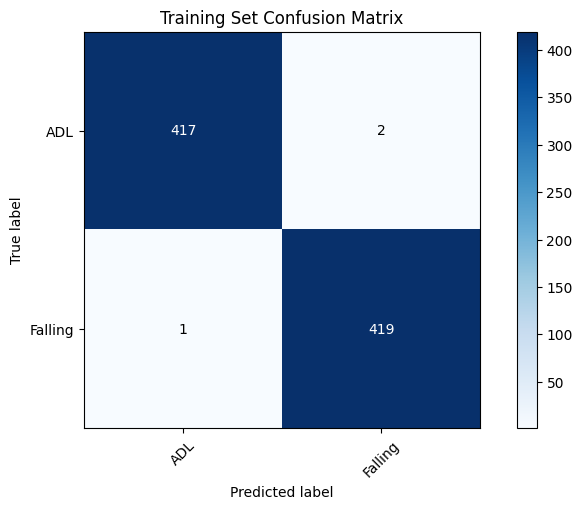

In [23]:
# Plotting
plt.figure(figsize=(15, 5))
label_names = ['ADL', 'Falling']
plt.subplot(1, 2, 1)
plot_confusion_matrix(y_train, y_train_pred, label_names, title='Training Set Confusion Matrix')


In [24]:
path = '/content/drive/MyDrive/FallDetectionAI/rf_model.pkl'

with open(path, 'wb') as file:
    pickle.dump(best_model, file)